# Calculating Monthly Overdose deaths from CDC data
Author: Samir Akre
Last Updated: Jan 3 2021

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.load_data as ld
import src.defilter_data as dd
import src.estimate_error as ee
import importlib
import scipy.stats as stats

## Import and clean data
- 'predicted_val' column is 12-month rolling sum of monthly overdose deaths
- 'Deaths' column are the imputed monthly overdose deaths

In [2]:
importlib.reload(dd)
importlib.reload(ld)
data = ld.load_data().dropna(how='all')
data

,timestamp,location,predicted_val,Deaths
64,2015-01-01,Alabama,742,65.0
63,2015-02-01,Alabama,749,60.0
62,2015-03-01,Alabama,758,79.0
61,2015-04-01,Alabama,764,69.0
60,2015-05-01,Alabama,782,74.0
...,...,...,...,...
3250,2020-05-01,Wyoming,88,NaN
3365,2020-06-01,Wyoming,84,NaN
3416,2020-07-01,Wyoming,88,NaN
3519,2020-08-01,Wyoming,89,NaN


## Impute/Predict 2020 monthly data
- 11 months of monthly death data used to "unroll" to 12 month rolling sum reported for 2020 months

In [11]:
k = 12 # 12 month rolling sum
time_filt = data[data.timestamp >= pd.to_datetime('2019-01-01')]
time_filt['raw_predicted_val'] = np.nan
for loc in time_filt['location'].unique():
    truth = time_filt.loc[time_filt.location == loc, 'Deaths'].values
    if time_filt.loc[data.location == loc, 'predicted_val'].iloc[11:].empty:
        continue
    pred = dd.defilter(time_filt.loc[data.location == loc, 'predicted_val'].iloc[11:].values, k, truth[:11])
    time_filt.loc[time_filt.location == loc, 'raw_predicted_val'] = pred
time_filt['raw_predicted_val'] = time_filt['raw_predicted_val'].astype(float)

<ipython-input-11-239acf451e39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filt['raw_predicted_val'] = np.nan
<ipython-input-11-239acf451e39>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filt['raw_predicted_val'] = time_filt['raw_predicted_val'].astype(float)


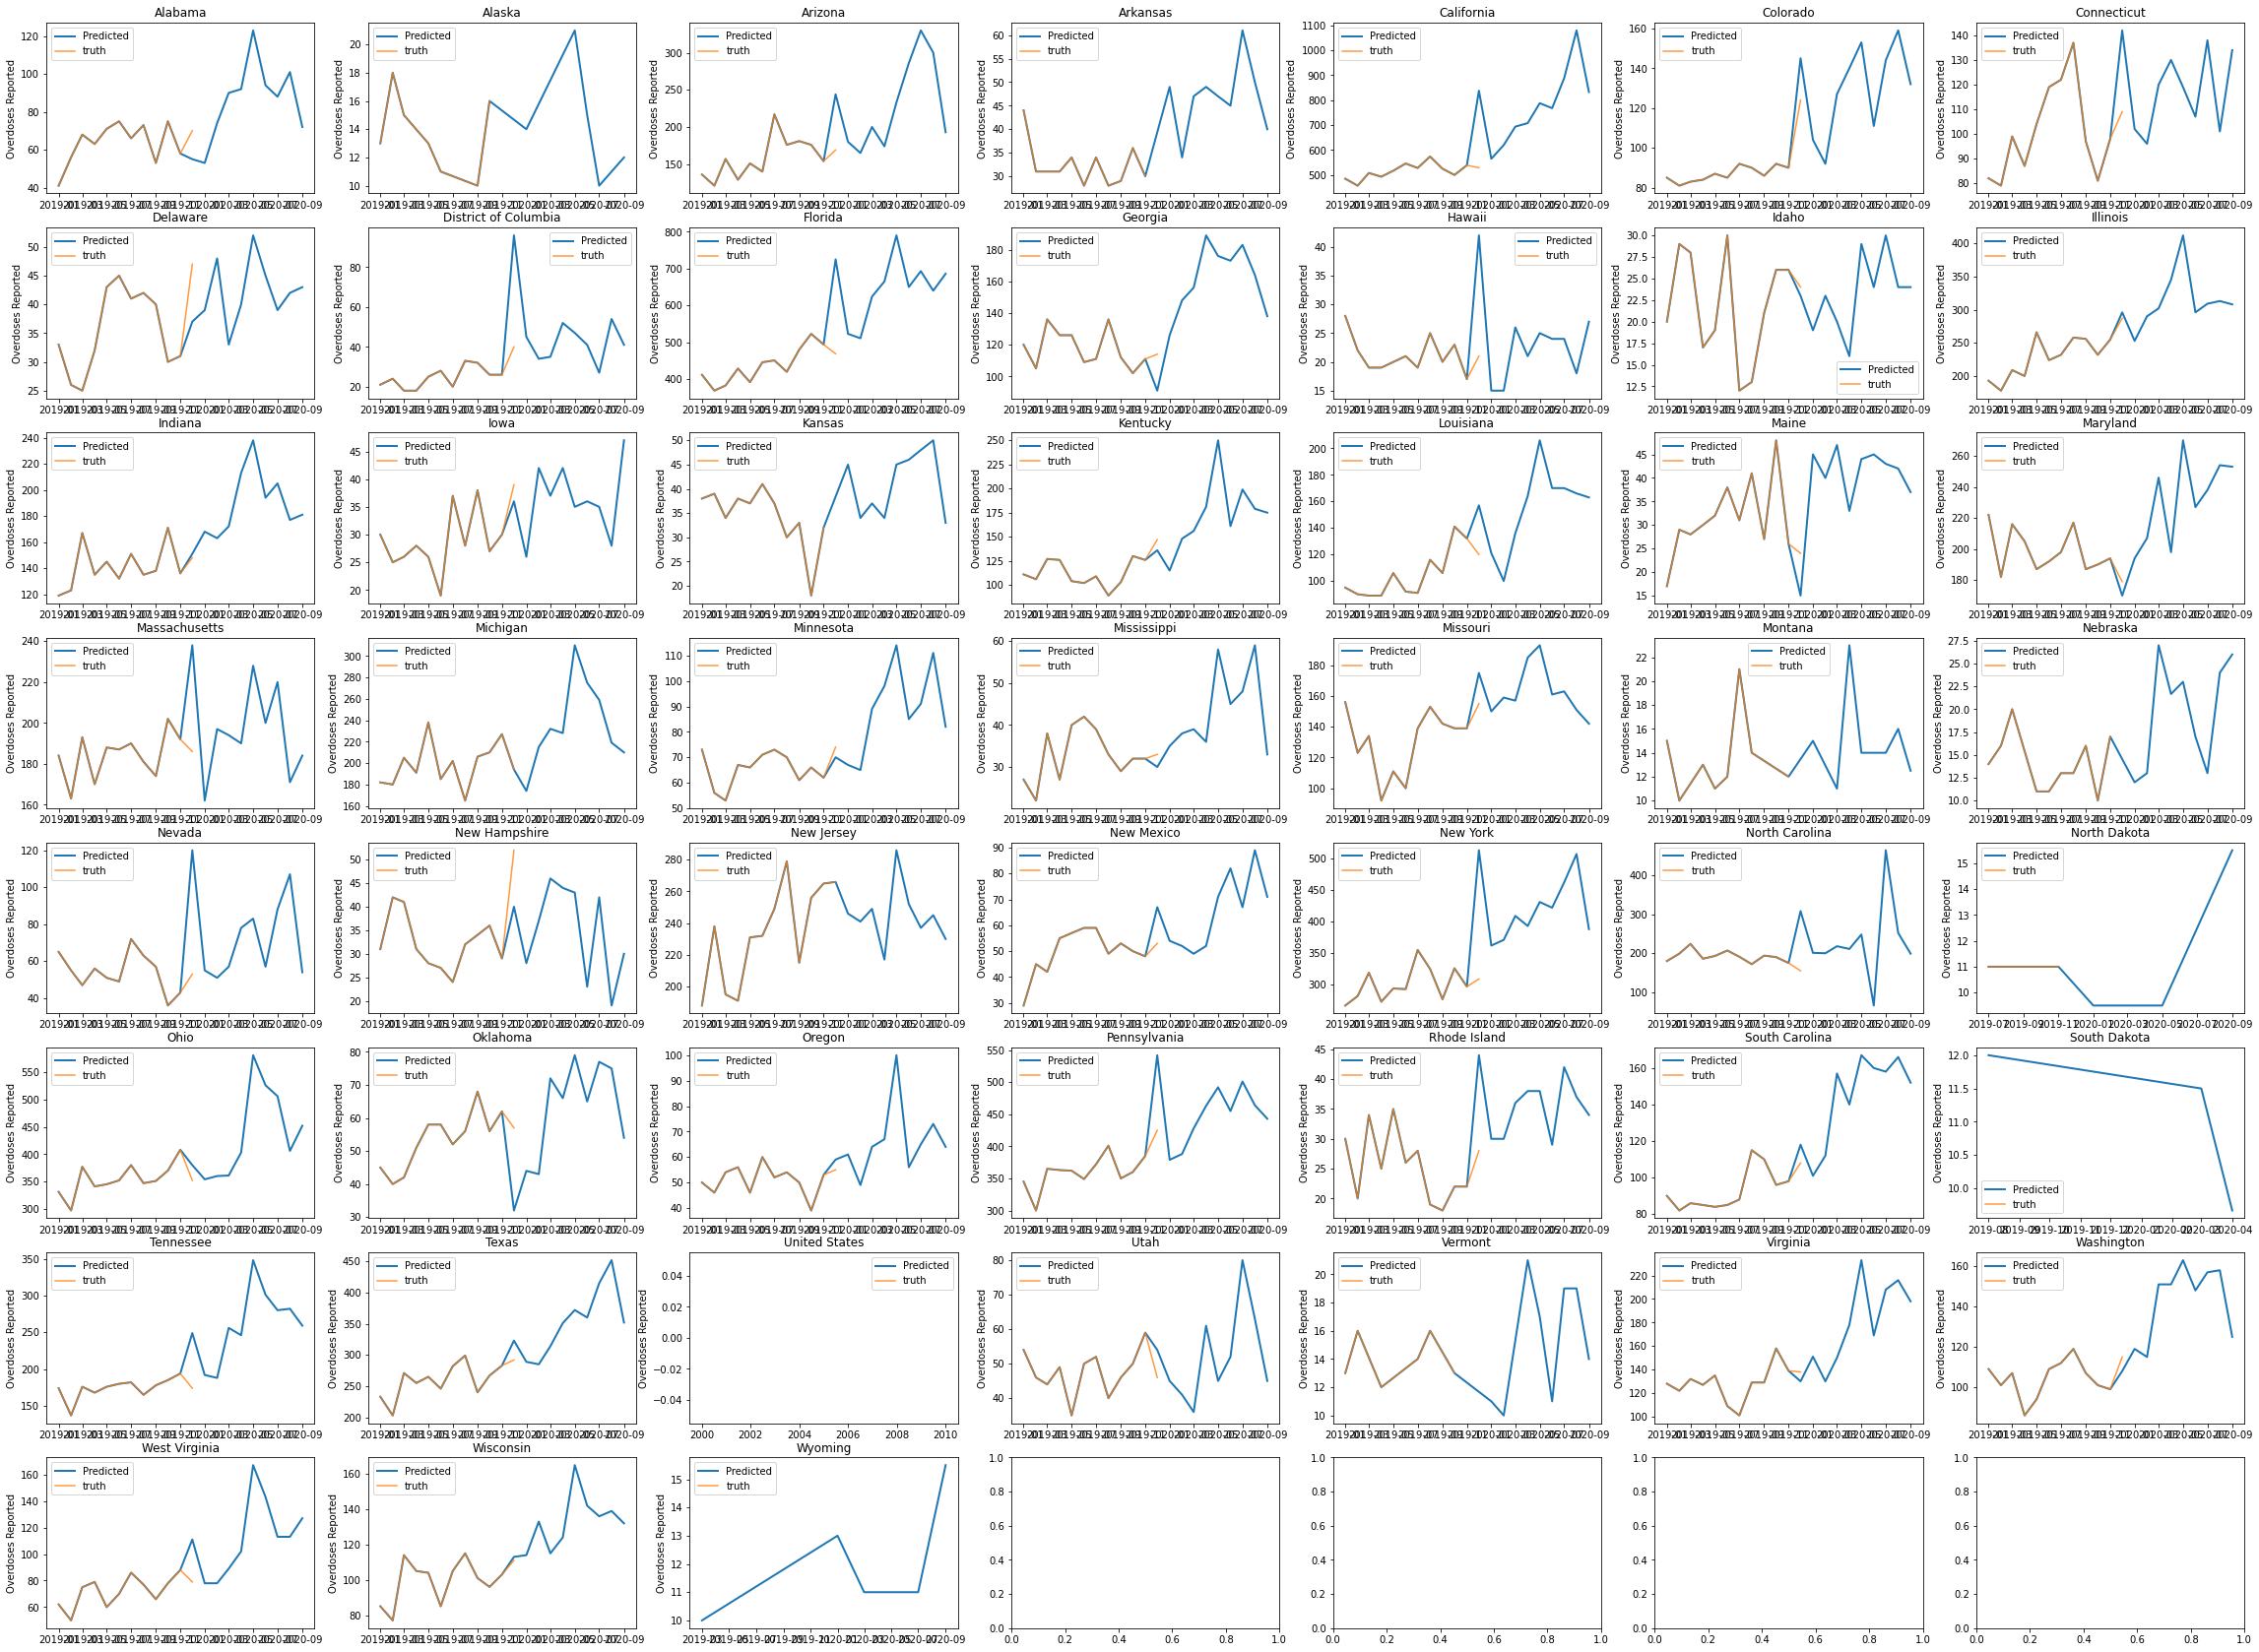

In [12]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in time_filt.groupby('location'):
    ax=axes.flatten()[i]
    filt_data = loc_data.copy()
    # Hides values less than 10 from plot
    for col in ['raw_predicted_val', 'Deaths']:
        filt_data.loc[filt_data[col] <= 9] = np.nan
    sns.lineplot(
        x='timestamp',
        y='raw_predicted_val',
        data=filt_data,
        label='Predicted',
        markers=True,
        lw=2,
        ax=ax
    )
    sns.lineplot(
        x='timestamp',
        y='Deaths',
        data=filt_data,
        label='truth',
        markers=True,
        alpha=.8,
        ax=ax
    )
    ax.set_ylabel('Overdoses Reported')
    ax.set_title(loc)
    ax.set_xlabel('')
    i+=1

In [13]:
time_filt[[
    'location', 'Deaths', 'timestamp', 'raw_predicted_val'
]].to_csv('output/monthly_overdose_computed_m2.csv', index=False)

In [14]:
time_filt[time_filt.Deaths.isna()].groupby('timestamp').raw_predicted_val.sum()

timestamp
2020-01-01    6356.0
2020-02-01    6522.0
2020-03-01    7356.0
2020-04-01    7703.0
2020-05-01    9192.0
2020-06-01    7888.0
2020-07-01    8850.0
2020-08-01    8606.0
2020-09-01    7718.0
Name: raw_predicted_val, dtype: float64

# Error Analysis

## Testing rolling sum unrolling method

In [15]:
time = np.arange(0, 12*6)/12
truth = np.random.randint(0, 1000, size=time.shape)
truth = np.sin(time*2) + 1
cumTruth = pd.Series(truth).rolling(window=12).sum().values


<AxesSubplot:>

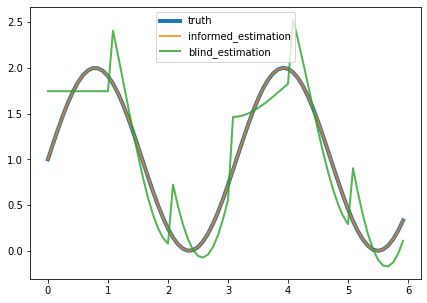

In [16]:
importlib.reload(dd)
fig, ax = plt.subplots(figsize=(7,5))
sns.lineplot(
    x=time,
    y=truth,
    label='truth',
    lw=4,
    ax=ax
)
sns.lineplot(
    x=time,
    y=dd.defilter(cumTruth[11:], 12, truth[:11]),
    label='informed_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)

sns.lineplot(
    x=time,
    y=dd.defilter(cumTruth[12:], 12),
    label='blind_estimation',
    lw=2,
    alpha=.8,
    ax=ax
)

## Discrepency in computed rolling sum of CDC monthly data vs reported rolling sum from CDC

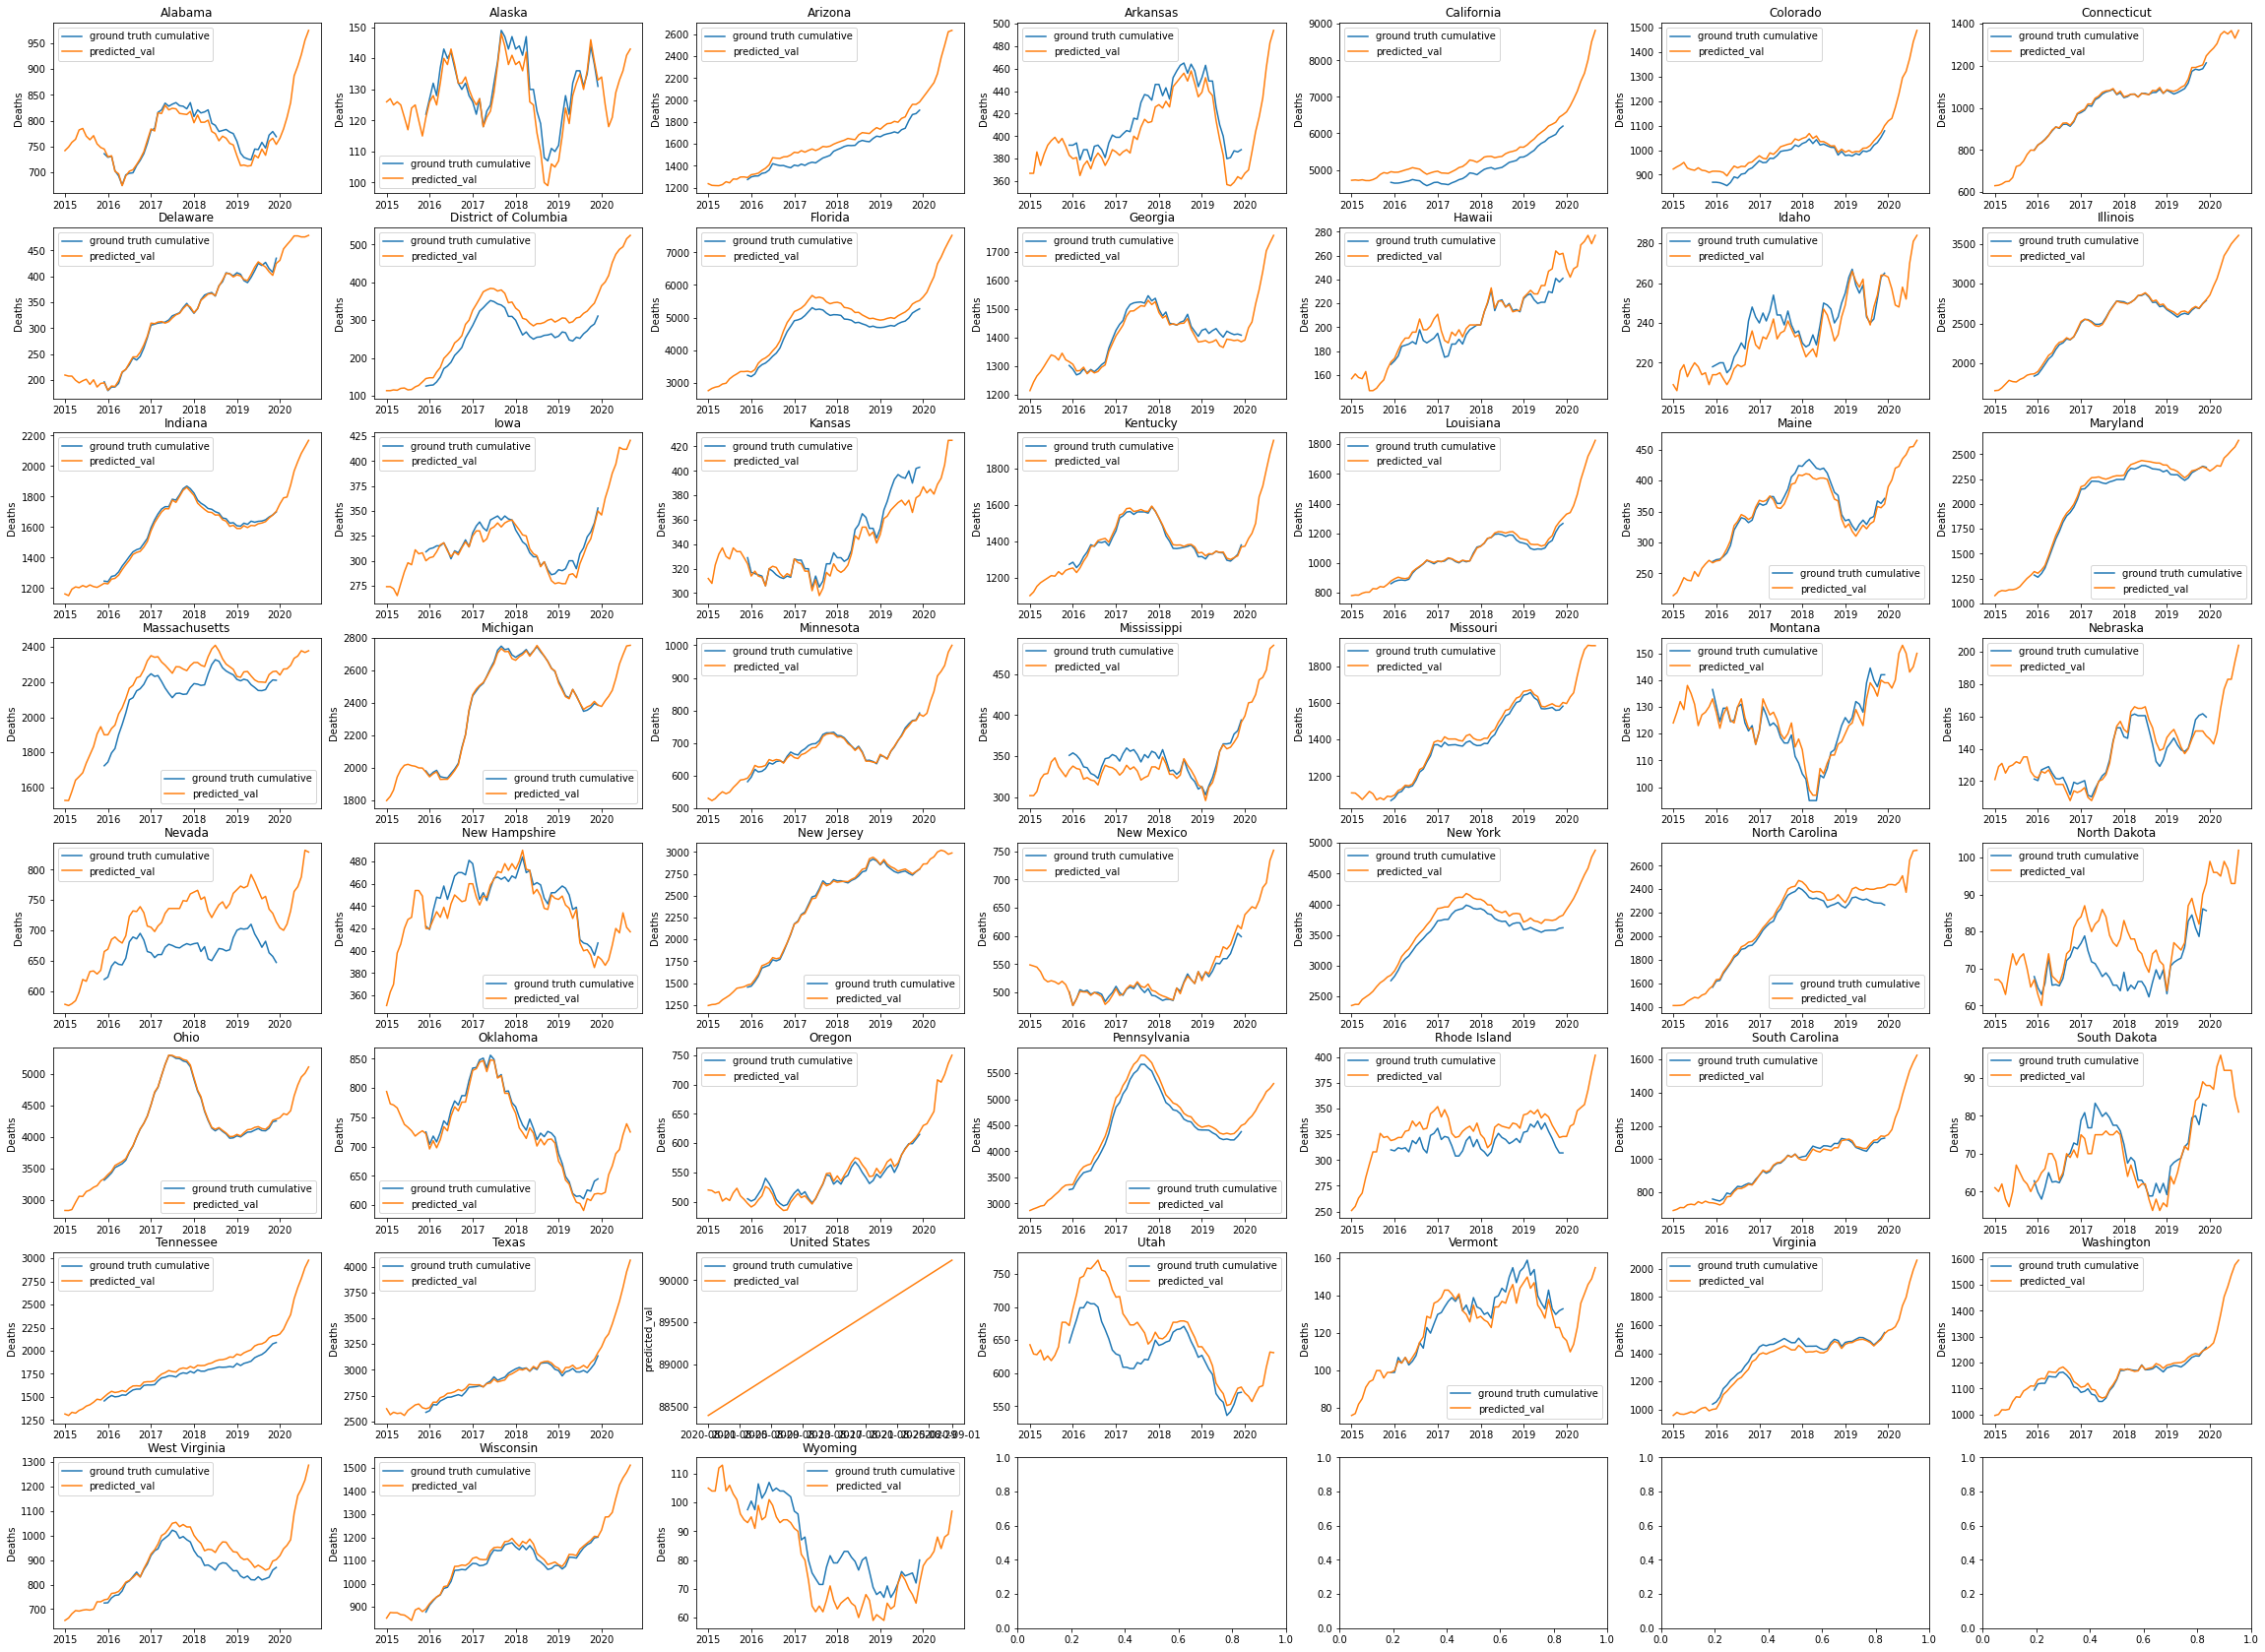

In [17]:
fig, axes = plt.subplots(nrows=8, ncols=7, figsize=(40,30))
i = 0
for loc, loc_data in data.groupby('location'):
    ax=axes.flatten()[i]
    int_loc = loc_data.loc[loc_data.Deaths != 'Suppressed']
    int_loc.Deaths = int_loc.Deaths.rolling(12).sum()
    sns.lineplot(
        y='Deaths',
        x='timestamp',
        data=int_loc,
        label='ground truth cumulative',
        ax=ax,
    )
    sns.lineplot(
        y='predicted_val',
        label='predicted_val',
        x='timestamp',
        data=int_loc,
        ax=ax
    )
    ax.vlines(loc_data.loc[loc_data.Deaths == 'Suppressed', 'timestamp'], *ax.get_ylim(), lw=1, alpha=.5, color='red')
    ax.set_title(loc)
    ax.set_xlabel('')

    i+=1


## Calculate prediction error at n-months out from 11 months of ground truth data used

In [22]:
data.dropna().shape, data.shape

((3060, 4), (3521, 4))

In [24]:
importlib.reload(ee)
error_data = ee.calculate_error(data.dropna(), max_months_out = 13)
error_data.to_csv('output/full_error.csv', index=False)
error_data

,location,pred_timestamp,truth,error,pred,percent_error,month_out
0,Alabama,2015-12-01,51.0,-9.0,60.0,17.647059,1
663,Alabama,2016-01-01,58.0,-1.0,59.0,1.724138,1
1,Alabama,2016-01-01,58.0,8.0,50.0,13.793103,2
1326,Alabama,2016-02-01,62.0,-1.0,63.0,1.612903,1
664,Alabama,2016-02-01,62.0,0.0,62.0,0.000000,2
...,...,...,...,...,...,...,...
23866,Wyoming,2019-10-01,8.5,2.5,6.0,29.411765,12
23204,Wyoming,2019-10-01,8.5,12.5,-4.0,147.058824,13
24529,Wyoming,2019-11-01,4.0,-0.5,4.5,12.500000,12
23867,Wyoming,2019-11-01,4.0,11.0,-7.0,275.000000,13


In [25]:
error_data[~error_data.error.isna()].pred_timestamp.nunique()

49

In [26]:
error_data.groupby('month_out').error.describe()

,count,mean,std,min,25%,50%,75%,max
month_out,,,,,,,,
1,1887.0,-26.809751,67.775388,-385.0,-28.0,-5.0,5.0,59.0
2,1887.0,-0.028087,5.660049,-34.0,-3.0,0.0,3.0,34.0
3,1887.0,-0.119237,5.681421,-34.0,-3.0,0.0,3.0,34.0
4,1887.0,-0.219926,5.768223,-34.0,-3.0,0.0,3.0,34.0
5,1887.0,-0.199788,5.789629,-34.0,-3.0,0.0,3.0,34.0
6,1887.0,-0.217806,5.792847,-34.0,-3.0,0.0,3.0,34.0
7,1887.0,-0.170641,5.782269,-34.0,-3.0,0.0,3.0,34.0
8,1887.0,-0.209857,5.848667,-34.0,-3.0,0.0,3.0,34.0
9,1887.0,-0.209327,5.849419,-34.0,-3.0,0.0,3.0,34.0


<AxesSubplot:xlabel='percent_error', ylabel='location'>

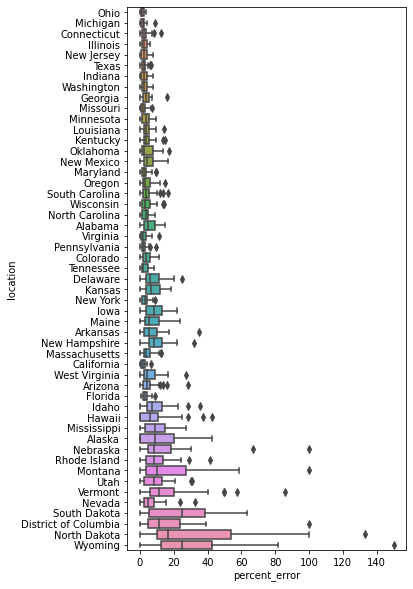

In [27]:
fig, ax = plt.subplots(figsize=(5,10))
m_last_error = error_data[error_data.month_out == 8]
order = error_data.groupby('location').percent_error.mean().sort_values().index
sns.boxplot(
    x='percent_error',
    y='location',
    data=m_last_error,
    order=order,
    ax=ax
)

## Summarize prediction error

In [28]:
stds = error_data.groupby(['location', 'month_out']).error.std()
abs_mean = error_data.groupby(['location', 'month_out']).error.apply(lambda x: np.mean(np.abs(x)))
mape = error_data.groupby(['location', 'month_out']).percent_error.apply(lambda x: np.mean(np.abs(x)))
std_pe = error_data.groupby(['location', 'month_out']).percent_error.std()
error_summary = pd.DataFrame(stds).rename(columns={'error': 'Std Error'}).reset_index().merge(
    pd.DataFrame(abs_mean).rename(columns={'error': 'Mean Absolute Error'}).reset_index()

).merge(
    pd.DataFrame(mape).rename(columns={'percent_error': 'Mean Absolute Percent Error'}).reset_index()
).merge(
    pd.DataFrame(std_pe).rename(columns={'percent_error': 'Std Percent Error'}).reset_index()
)
error_summary.to_csv('output/prediction_error_summary.csv', index=False)
error_summary

,location,month_out,Std Error,Mean Absolute Error,Mean Absolute Percent Error,Std Percent Error
0,Alabama,1,9.314008,9.486486,15.017504,11.405761
1,Alabama,2,4.176655,3.486486,5.623928,4.209549
2,Alabama,3,4.082851,3.378378,5.444192,3.987158
3,Alabama,4,4.381404,3.621622,5.801903,4.077836
4,Alabama,5,4.379347,3.594595,5.738814,4.125513
...,...,...,...,...,...,...
658,Wyoming,9,2.311919,1.770270,31.382504,30.784301
659,Wyoming,10,2.231867,1.729730,30.713263,30.152198
660,Wyoming,11,2.266415,1.770270,31.057725,30.059930
661,Wyoming,12,2.262353,1.756757,31.009463,30.089026
